# Deconvolving microscopy images with the help of DeconvTest

(For the details on the DeconvTest framework see the <a href="https://applied-systems-biology.github.io/DeconvTest/">online documentation</a>

DeconvTest can help to deconvolve real microscopy images by identifying the optimal deconvolution parameters. For this, we first need to identify the properties of our microscopy images such as voxel size, PSF size, noise SNR, and the size of the features of interest. We then generate synthetic data with the same properties and deconvolve them with different settings using DeconvTest, which allows us to identify the deconvolution settings that result in the lowest errors. Finally, we can apply the identified algorithm and settings to reconstruct real microscopy images either within DeconvTest or using other software.


## Identifying image properties

Thus, as the first step, we need to determine important image properties. Many of these can be identified using ImageJ.


### Voxel size

To check the voxel size of the image, go to Image -> Properties:

￼<img src="img/imgprop.png" width="200">


### Size of the features of interest

To measure the size of the features of interest, e.g. cells, select the line tool and measure the size of a few objects. The length of the line will be displayed on the main panel of ImageJ using the same units that are set in the Image Properties:

￼<img src="img/cellsize1.png" width="600">

￼<img src="img/cellsize2.png" width="600">


### Signal-to-noise ratio

To measure the signal-to-noise ratio (SNR), run Analyze -> Set Measurements and select Standard deviation and Mean gray value to be computed. 

￼<img src="img/set_measurements.png" width="400">

After that, select a few regions (e.g. with the elliptical selection tool) that are relatively bright but not over-saturated and run Analyze -> Measure.

￼<img src="img/snr1.png" width="600">

￼<img src="img/snr2.png" width="600">

Divide the computed Mean gray value by the standard deviation to estimate SNR for each region. Take the smallest value for a conservative estimate.

### Size of the point spread function

To estimate the size of the PSF, we need a PSF image, which can be either generated theoretically (e.g. using [Huygens](https://svi.nl/TheoreticalPsf) or [ImageJ/Fiji](http://bigwww.epfl.ch/algorithms/psfgenerator/)) or measured by imaging fluorescent beads.

For the purpose of this tutorial, you can download a PSF that we reconstructed from our image data:

In [1]:
import urllib.request
urllib.request.urlretrieve('https://github.com/applied-systems-biology/DeconvTest/blob/master/docs/data/microscopy/real_data/psf_measured.tif?raw=true', './psf_measured.tif')
urllib.request.urlretrieve('https://github.com/applied-systems-biology/DeconvTest/blob/master/docs/data/microscopy/real_data/psf_measured.csv?raw=true', './psf_measured.csv')

('./psf_measured.csv', <http.client.HTTPMessage at 0x7fca62757160>)

In [2]:
from DeconvTest import PSF
psf = PSF(filename='./psf_measured.tif')
psf.show_2d_projections()

/home/anna/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


DeconvTest provides tools to measure the size of the PSF by approximating it with a Gaussian function:

In [3]:
sigmas = psf.measure_psf_sigma()
sigmas

array([1.85119242, 3.34716592, 3.35760041])

The measured values are in pixels and need to be multiplied by the corresponding voxel size to obtain the values in micrometers:

In [4]:
import numpy as np
sigmas = sigmas * np.array([3, 0.415, 0.415])
sigmas

array([5.55357725, 1.38907386, 1.39340417])

The aspect ratio of the PSF can be computed by dividing the standard deviation in z (the first value) by the standard deviation in x or y (the second or third value):

In [5]:
aspect = sigmas[0] / sigmas[1]
aspect

3.9980431713697064

## Running DeconvTest workflow with identified image properties

Now, when the microscopy image properties have been identified, we can adjust the DeconvTest configuration file to generate synthetic images with the same properties and deconvolve them with desired algorithms and parameters. For the purpose of this tutorial (to reduce computation time), we will generate only two cells and vary only a few deconvolution parameters. However, to obtain the most accurate results one should generally test many parameter values and generate at least 10 cell, as well as generate cells with a smaller input voxel size (e.g. 0.1 $\mu m$).

In [6]:
import pandas as pd
config = pd.Series({'simulation_folder': 'my_deconvtest_simulation/',
                    'simulation_steps': ['generate_cells', 'generate_psfs', 
                                         'convolve', 'resize', 'add_noise', 'deconvolve', 'accuracy'],
                    'max_threads': 4,
                    'number_of_cells': 2,
                    'size_mean_and_std': (15, 3),
                    'input_voxel_size': 0.3,
                    'psf_sigmas': 1.4,
                    'psf_aspect_ratios': 4,
                    'voxel_sizes_for_resizing': [[3, 0.45, 0.45]],
                    'noise_kind': ['poisson'],
                    'snr': 2,
                    'deconvolution_algorithm': ['deconvolution_lab_rif', 
                                                'deconvolution_lab_rltv', 'iterative_deconvolve_3d'],
                    'deconvolution_lab_rif_regularization_lambda': [0.01, 0.1, 1],
                    'deconvolution_lab_rltv_regularization_lambda': [0.01, 0.05],
                    'deconvolution_lab_rltv_iterations': 5,
                    'iterative_deconvolve_3d_detect': 'FALSE',
                    'iterative_deconvolve_3d_low': 2,
                    'iterative_deconvolve_3d_normalize': 'TRUE',
                    'iterative_deconvolve_3d_perform': 'TRUE',
                    'iterative_deconvolve_3d_terminate': 0.1,
                    'iterative_deconvolve_3d_wiener': [0, 1.0]
                    })
config.to_csv('config_microscopy_data.csv', sep='\t', header=False)
config

simulation_folder                                                       my_deconvtest_simulation/
simulation_steps                                [generate_cells, generate_psfs, convolve, resi...
max_threads                                                                                     4
number_of_cells                                                                                 2
size_mean_and_std                                                                         (15, 3)
input_voxel_size                                                                              0.3
psf_sigmas                                                                                    1.4
psf_aspect_ratios                                                                               4
voxel_sizes_for_resizing                                                        [[3, 0.45, 0.45]]
noise_kind                                                                              [poisson]
snr                 

We are now ready to run the DeconvTest simulation. Run `python run_simulation.py config_microscopy_data.csv` in the terminal, or the following command in the jupyter notebook:

In [7]:
import os
os.system('run_simulation.py config_microscopy_data.csv')

0

This will take a few minutes to compute. After the simulation is finished, DeconvTest will generate a csv table with NRMSE values for all applied algorithms and parameter combinations:

In [8]:
accuracy = pd.read_csv('my_deconvtest_simulation/accuracy_measures.csv', sep='\t')
accuracy[:10]

,Unnamed: 0,CellID,Convolved,Deconvolution algorithm,NRMSE,Name,PSF aspect ratio,PSF sigma xy um,RMSE,SNR,...,regularization_lambda,size_x,size_y,size_z,terminate,theta,wiener,x,y,z
0,0,1.0,True,deconvolution_lab_rltv,0.379929,deconvolution_lab_rltv_regularization_lambda=0...,4.0,1.4,96.881959,2.0,...,0.01,9.190666,11.890027,8.093678,NaN,1.190232,NaN,0.353955,0.198674,0.373585
1,1,0.0,True,deconvolution_lab_rltv,0.249720,deconvolution_lab_rltv_regularization_lambda=0...,4.0,1.4,63.678550,2.0,...,0.01,13.406367,19.478290,18.638135,NaN,0.810473,NaN,0.543023,0.675182,0.605230
2,2,1.0,True,deconvolution_lab_rif,0.613981,deconvolution_lab_rif_regularization_lambda=0....,4.0,1.4,156.565239,2.0,...,0.10,9.190666,11.890027,8.093678,NaN,1.190232,NaN,0.353955,0.198674,0.373585
3,3,0.0,True,deconvolution_lab_rif,0.308405,deconvolution_lab_rif_regularization_lambda=0....,4.0,1.4,78.643177,2.0,...,0.10,13.406367,19.478290,18.638135,NaN,0.810473,NaN,0.543023,0.675182,0.605230
4,4,1.0,True,deconvolution_lab_rif,0.682765,deconvolution_lab_rif_regularization_lambda=0....,4.0,1.4,174.105074,2.0,...,0.01,9.190666,11.890027,8.093678,NaN,1.190232,NaN,0.353955,0.198674,0.373585
5,5,0.0,True,deconvolution_lab_rif,0.487423,deconvolution_lab_rif_regularization_lambda=0....,4.0,1.4,124.292869,2.0,...,0.01,13.406367,19.478290,18.638135,NaN,0.810473,NaN,0.543023,0.675182,0.605230
6,6,1.0,True,deconvolution_lab_rif,0.461242,deconvolution_lab_rif_regularization_lambda=1....,4.0,1.4,117.616836,2.0,...,1.00,9.190666,11.890027,8.093678,NaN,1.190232,NaN,0.353955,0.198674,0.373585
7,7,0.0,True,deconvolution_lab_rif,0.259388,deconvolution_lab_rif_regularization_lambda=1....,4.0,1.4,66.144005,2.0,...,1.00,13.406367,19.478290,18.638135,NaN,0.810473,NaN,0.543023,0.675182,0.605230
8,8,1.0,True,iterative_deconvolve_3d,0.184532,iterative_deconvolve_3d_detect=False_low=2.0_n...,4.0,1.4,47.055676,2.0,...,NaN,9.190666,11.890027,8.093678,0.1,1.190232,0.0,0.353955,0.198674,0.373585
9,9,0.0,True,iterative_deconvolve_3d,0.189305,iterative_deconvolve_3d_detect=False_low=2.0_n...,4.0,1.4,48.272838,2.0,...,NaN,13.406367,19.478290,18.638135,0.1,0.810473,0.0,0.543023,0.675182,0.605230


Here, the NRMSE values are provided per cell. To obtain average performance, we need to average among all deconvolved cells.

First, let's extract the algorithm name and the settings from the file name:

In [9]:
for i in range(len(accuracy)):
        setting = accuracy.iloc[i]['Name'].split('/')[-3]
        accuracy.at[i, 'Settings'] = setting

Then, we group by the extracted settings, compute the mean value and sort by NRMSE:

In [10]:
accuracy_summary = accuracy.groupby(['Settings']).mean().reset_index().sort_values('NRMSE')
accuracy_summary[:10]

,Settings,Unnamed: 0,CellID,Convolved,NRMSE,PSF aspect ratio,PSF sigma xy um,RMSE,SNR,Voxel size x,...,regularization_lambda,size_x,size_y,size_z,terminate,theta,wiener,x,y,z
6,iterative_deconvolve_3d_detect=False_low=2.0_n...,10.5,0.5,True,0.131516,4.0,1.4,33.536601,2.0,0.45,...,NaN,11.298516,15.684159,13.365906,0.1,1.000352,1.0,0.448489,0.436928,0.489408
5,iterative_deconvolve_3d_detect=False_low=2.0_n...,8.5,0.5,True,0.186919,4.0,1.4,47.664257,2.0,0.45,...,NaN,11.298516,15.684159,13.365906,0.1,1.000352,0.0,0.448489,0.436928,0.489408
4,deconvolution_lab_rltv_regularization_lambda=0...,12.5,0.5,True,0.294310,4.0,1.4,75.048985,2.0,0.45,...,0.05,11.298516,15.684159,13.365906,NaN,1.000352,NaN,0.448489,0.436928,0.489408
3,deconvolution_lab_rltv_regularization_lambda=0...,0.5,0.5,True,0.314825,4.0,1.4,80.280254,2.0,0.45,...,0.01,11.298516,15.684159,13.365906,NaN,1.000352,NaN,0.448489,0.436928,0.489408
2,deconvolution_lab_rif_regularization_lambda=1.0,6.5,0.5,True,0.360315,4.0,1.4,91.880420,2.0,0.45,...,1.00,11.298516,15.684159,13.365906,NaN,1.000352,NaN,0.448489,0.436928,0.489408
1,deconvolution_lab_rif_regularization_lambda=0.1,2.5,0.5,True,0.461193,4.0,1.4,117.604208,2.0,0.45,...,0.10,11.298516,15.684159,13.365906,NaN,1.000352,NaN,0.448489,0.436928,0.489408
0,deconvolution_lab_rif_regularization_lambda=0.01,4.5,0.5,True,0.585094,4.0,1.4,149.198972,2.0,0.45,...,0.01,11.298516,15.684159,13.365906,NaN,1.000352,NaN,0.448489,0.436928,0.489408


The first line in the table now corresponds to the optimal deconvolution settings:

In [11]:
accuracy_summary.iloc[0]

Settings                 iterative_deconvolve_3d_detect=False_low=2.0_n...
Unnamed: 0                                                            10.5
CellID                                                                 0.5
Convolved                                                             True
NRMSE                                                             0.131516
PSF aspect ratio                                                         4
PSF sigma xy um                                                        1.4
RMSE                                                               33.5366
SNR                                                                      2
Voxel size x                                                          0.45
Voxel size y                                                          0.45
Voxel size z                                                             3
iterations                                                             NaN
low                      

Thus, DAMAS was identified as the optimal algorithm.

For the following parameters, only one value was tested:

- Normalize PSF: True
- Detect divergence: False
- Perform antiringing step: True
- Terminate iteration: 0.1
- Low pass filter: 2

But for the Wiener filter, the value $\gamma = 1$ was identified as optimal



## Deconvolving microscopy images with identified optimal settings

### Using external deconvolution software

The real microscopy image can now be deconvolved with identified optimal settings. This can be done directly with the corresponding Fiji plugin by choosing the optimal parameter values. Make sure that the specified input and psf image have the same voxel size:

￼<img src="img/damas_optimal.png" width="600">

### Using DeconvTest

Alternatively, the user can deconvolve images from within DeconvTest. 

Let's download some example microscopy data ...

In [12]:
if not os.path.exists('./my_deconvtest_simulation2/data_to_deconvolve/psf_measured/'):
    os.makedirs('./my_deconvtest_simulation2/data_to_deconvolve/psf_measured/')
urllib.request.urlretrieve('https://github.com/applied-systems-biology/DeconvTest/blob/master/docs/data/microscopy/real_data/psf_measured/MC.tif?raw=true', './my_deconvtest_simulation2/data_to_deconvolve/psf_measured/MC.tif')
urllib.request.urlretrieve('https://github.com/applied-systems-biology/DeconvTest/blob/master/docs/data/microscopy/real_data/psf_measured/MC.csv?raw=true', './my_deconvtest_simulation2/data_to_deconvolve/psf_measured/MC.csv')

('./my_deconvtest_simulation2/data_to_deconvolve/psf_measured/MC.csv',
 <http.client.HTTPMessage at 0x7fca2a3c9fd0>)

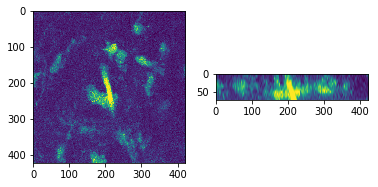

In [13]:
from skimage import io
from scipy import ndimage
img = io.imread('my_deconvtest_simulation2/data_to_deconvolve/psf_measured/MC.tif')
c = io.imshow_collection([img.max(0), ndimage.zoom(img.max(1), zoom=[3/0.45,1])])

... and copy our psf image to the corresponding folder:

In [14]:
import shutil
shutil.copy('psf_measured.tif', 'my_deconvtest_simulation2/data_to_deconvolve/psf_measured.tif')
shutil.copy('psf_measured.csv', 'my_deconvtest_simulation2/data_to_deconvolve/psf_measured.csv')

'my_deconvtest_simulation2/data_to_deconvolve/psf_measured.csv'

The image data to deconvolve have to be stored in a subfolder that has the same name as the corresponding PSF image, in this case "psf_measured/":

In [15]:
os.listdir('my_deconvtest_simulation2/data_to_deconvolve')

['psf_measured.tif', 'psf_measured', 'psf_measured.csv']

In [16]:
os.listdir('my_deconvtest_simulation2/data_to_deconvolve/psf_measured')

['MC.tif', 'MC.csv']

Image metadata must contain the voxel size values:

In [17]:
pd.read_csv('my_deconvtest_simulation2/data_to_deconvolve/psf_measured/MC.csv', sep='\t', index_col=0, header=None).squeeze()

0
Voxel size z    3.00
Voxel size y    0.45
Voxel size x    0.45
Name: 1, dtype: float64

In [18]:
pd.read_csv('my_deconvtest_simulation2/data_to_deconvolve/psf_measured.csv', sep='\t', index_col=0, header=None).squeeze()

0
Voxel size z       3
Voxel size y    0.45
Voxel size x    0.45
isPSF           True
Name: 1, dtype: object

Next, we need to specify a configuration file to deconvolve our microscopy data:

In [19]:
config = pd.Series({'simulation_folder': 'my_deconvtest_simulation2/',
                    'simulation_steps': ['deconvolve'],
                    'inputfolder': 'data_to_deconvolve',
                    'deconvolve_results_folder': 'deconvolved',
                    'max_threads': 1,
                    'deconvolution_algorithm': ['iterative_deconvolve_3d'],
                    'iterative_deconvolve_3d_detect': 'FALSE',
                    'iterative_deconvolve_3d_low': 2,
                    'iterative_deconvolve_3d_normalize': 'TRUE',
                    'iterative_deconvolve_3d_perform': 'TRUE',
                    'iterative_deconvolve_3d_terminate': 0.1,
                    'iterative_deconvolve_3d_wiener': 1
                    })
config.to_csv('config_microscopy_data_deconvolve.csv', sep='\t', header=False)
config

simulation_folder                    my_deconvtest_simulation2/
simulation_steps                                   [deconvolve]
inputfolder                                  data_to_deconvolve
deconvolve_results_folder                           deconvolved
max_threads                                                   1
deconvolution_algorithm               [iterative_deconvolve_3d]
iterative_deconvolve_3d_detect                            FALSE
iterative_deconvolve_3d_low                                   2
iterative_deconvolve_3d_normalize                          TRUE
iterative_deconvolve_3d_perform                            TRUE
iterative_deconvolve_3d_terminate                           0.1
iterative_deconvolve_3d_wiener                                1
dtype: object

Finally, we can run the specified DeconvTest by running `python run_simulation.py config_microscopy_data_deconvolve.csv` in the terminal, or the following command in the jupyter notebook:

In [20]:
os.system('run_simulation.py config_microscopy_data_deconvolve.csv')

0

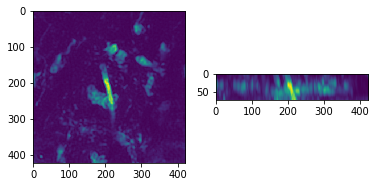

In [21]:
img = io.imread('my_deconvtest_simulation2/deconvolved/iterative_deconvolve_3d_detect=False_low=2.0_normalize=True_perform=True_terminate=0.1_wiener=1.0/psf_measured/MC.tif')
c = io.imshow_collection([img.max(0), ndimage.zoom(img.max(1), zoom=[3/0.45,1])])